In [1]:
#!pip install torch torchvision numpy opencv-python segment_anything supervision shapely scipy pip install fiona rasterio

In [2]:
#!unzip "/content/drive/MyDrive/DADOS_SOBREVOO_SOS PANTANAL/2023/drive-download-20230414T011428Z-001.zip" -d "/content/drive/MyDrive/DADOS_SOBREVOO_SOS PANTANAL/2023"

In [3]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import PIL
import glob
import os

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True


libpng warning: iCCP: known incorrect sRGB profile


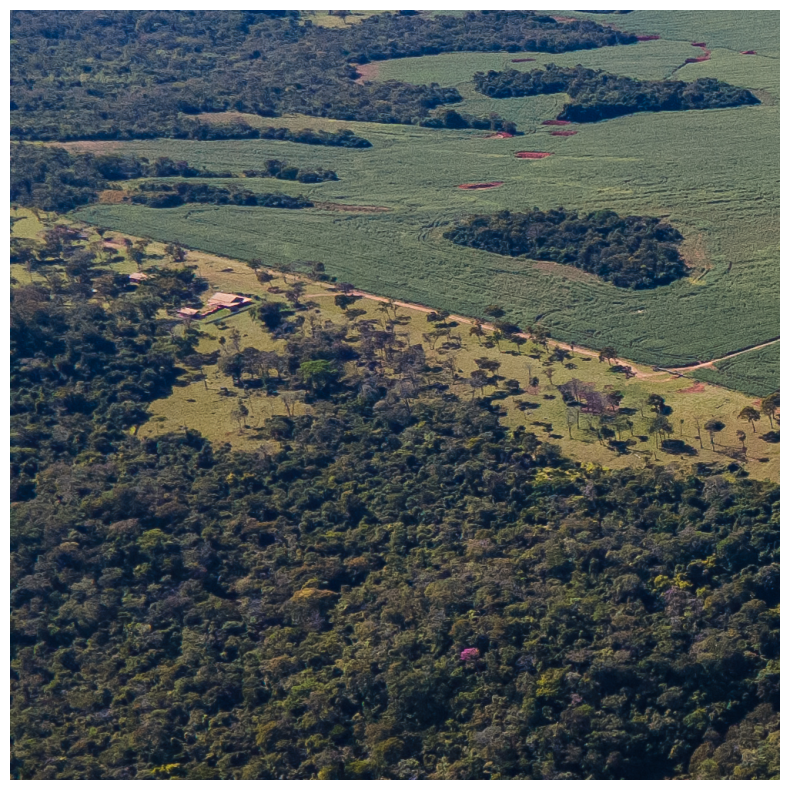

In [4]:
# path_image_i = '/home/wesley/josemartins/images/diadaarvore1.jpg'
path_image_i = '/home/wesley/josemartins/output_clip_1000/Ponto extra 3 (1 de 6)_0_1.png'
image = cv2.imread(path_image_i)  #Try houses.jpg or neurons.jpg
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
# import required module
from PIL import Image
  
# get image
filepath = "/home/wesley/josemartins/images/diadaarvore1.jpg"
img = Image.open(filepath)
  
# get width and height
width = img.width
height = img.height
  
# display width and height
print("The height of the image is: ", height)
print("The width of the image is: ", width)
print(type(width))

The height of the image is:  1100
The width of the image is:  2000
<class 'int'>


In [6]:
sam_checkpoint = "path_to/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
#There are several tunable parameters in automatic mask generation that control 
# how densely points are sampled and what the thresholds are for removing low 
# quality or duplicate masks.

mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=20,
    pred_iou_thresh=0.95,     
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=300,  # Requires open-cv to run post-processing
)

masks = mask_generator_.generate(image)

print((masks))
mask_list = list(masks)
print(mask_list)

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

Codigo otimizado para pegar os pontos com numpy

In [ ]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def from_binary_image(img, simplify_tolerance=0.05):
    
    unique_values = np.unique(img.astype(np.uint8))
       
    shapes = [] 

    for cat in unique_values:
        if cat == 0: continue

        img_ = img.copy()
        img_[img_ != cat] = 0
        img_[img_ != 0] = 1
        contours, hierarchy = cv2.findContours(img_, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        interiors = []
        index = []
        for c, contour in enumerate(contours):
            if hierarchy[0][c][3] != -1:
                interiors.append([(x[0][1], x[0][0]) for x in contour])
                index.append(hierarchy[0][c][3])

        for c, contour in enumerate(contours):
            if hierarchy[0][c][3] == -1:
                exterior = [(x[0][1], x[0][0]) for x in contour]
                interior = [hole for h, hole in enumerate(interiors) if index[h] == c]
                if len(exterior) <= 3: continue
                poly = Polygon(exterior, interior)
                poly = poly.simplify(tolerance=simplify_tolerance, preserve_topology=True)
                poly = poly.buffer(0)
                if not ( isinstance(poly, MultiPolygon)):
                    print(type(poly))
                    shapes.append(poly)
    return shapes

In [42]:
import json

# Define o nome do arquivo .json que será criado
filename = "novo_labels_jose2.json"

# Define o número de labels a serem geradas
num_labels = len(masks)

# Cria uma lista vazia para armazenar as informações dos labels
labels = []

for i in range(len(masks)):
    shapes = from_binary_image(masks[i]['segmentation'].astype(np.uint8), simplify_tolerance=2)
    for shape in shapes:
        #print("Classe: ", i)
        # print((i, shape.exterior.coords[:]))
        
        # Define o nome do label com base no valor de i
        label_name = f"label_{i}"

        # Define os pontos para o label com base no valor de i
        # pontos_array = class_points
        aux_pontos = [list(t) for t in shape.exterior.coords[:]]
        pontos = []
        for ponto in aux_pontos:
            pontos.append([ponto[1], ponto[0]])
        
        #print("aux_pontos: ", aux_pontos)
        #print("pontos: ", pontos)

        # Define as informações do label
        label_info = {
            "label": label_name,
            "points": pontos,
            "group_id": None,
            "description": "",
            "shape_type": "polygon",
            "flags": {}
        }

        # Adiciona o label à lista de labels
        labels.append(label_info)


# Define as informações adicionais do arquivo
info = {
    "version": "5.2.0.post4",
    "flags": {},
    "shapes": labels,
    "imagePath": path_image_i,
    "imageData": None,
    #"imageHeight": 1080,
    #"imageWidth": 1920
}
        
# Cria o arquivo .json e adiciona as informações
with open(filename, 'w') as outfile:
    
    json.dump(info, outfile)

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
